In [1]:
from tabulate import tabulate

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

In [3]:
import numpy as np

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
from fairness.utils import *
from fairness.mixture import *

In [6]:
%matplotlib inline

In [7]:
n, d = 1000, 10

In [8]:
p1, p0, p = .25, .5, .5

In [9]:
cov0 = np.diag(np.random.rand(d))
cov1 = np.eye(d)

In [10]:
mu00 = np.zeros(d); mu00[[0, -1]] = [-4, -2]
mu11 = np.zeros(d); mu11[[0, -1]] = [.5, -2]
mu01 = np.zeros(d); mu01[0] = -2
mu10 = np.zeros(d); mu10[0] = 1.3

In [11]:
args = (p0, p1, mu00, mu01, mu10, mu11, cov0, cov1)

We simulate a Gaussian mixture model with the following: 

        S ~ B(p)
        Y | S = 1 ~ B(p1)
        Y | S = 0 ~ B(p0)

        X | Y = 1, S = 1 ~ N(μ11, Σ1)
        X | Y = 1, S = 0 ~ N(μ10, Σ0)
        X | Y = 0, S = 1 ~ N(μ01, Σ1)
        X | Y = 0, S = 0 ~ N(μ00, Σ0)

In [12]:
X, S, y = generate_samples(n, d, p, *args)

We display the true unfairness of the synthetic data as a function of the probabilities of having a positive outcome while being part of the sensitive and non-sensitive group.

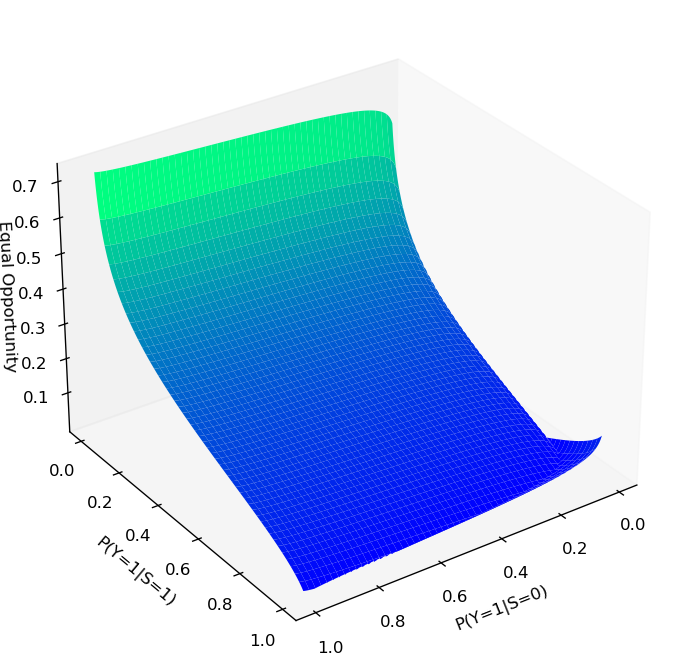

In [13]:
p0_span = np.linspace(.01, .99, 1000)
p1_span = np.linspace(.01, .99, 1000)

px, py = np.meshgrid(p0_span, p1_span)

fig = plt.figure(dpi=120, figsize=[7,7])
ax = plt.axes(projection='3d')
ax.grid(False)
ax.view_init(30, 55)
ax.zaxis.labelpad=-0.7
ax.plot_surface(px, py, equal_opportunity(np.ravel(px), np.ravel(py), mu00, mu01, mu10, mu11, cov0, cov1).reshape(1000, 1000), cmap='winter');
ax.set_xlabel('P(Y=1|S=0)');
ax.set_ylabel('P(Y=1|S=1)');
ax.set_zlabel('Equal Opportunity');


In [14]:
print(f'The fairness for this toy model is: {equal_opportunity(*args).item():.3f}')

The fairness for this toy model is: 0.291


In [15]:
def plot(X, y, S):
    fig = plt.figure(dpi=120)
    ax = fig.add_subplot()
    s_mask = S == 1
    y_mask = y == 1
    
    ax.scatter(X[s_mask & y_mask, 0], X[s_mask & y_mask, 1], c='green', marker='_', s=33, label='S=1 & Y=1');
    ax.scatter(X[~s_mask & y_mask, 0], X[~s_mask & y_mask, 1], c='purple', alpha=.5, marker='+', s=33, label='S=0 & Y=1');
    ax.scatter(X[s_mask & ~y_mask, 0], X[s_mask & ~y_mask, 1], c='orange', marker='x', s=33, label='S=1 & Y=0');
    ax.scatter(X[~s_mask & ~y_mask, 0], X[~s_mask & ~y_mask, 1], c='red', marker='*', s=33, label='S=0 & Y=0');
    fig.legend(ncol=2, bbox_to_anchor=[.99, 1.15])
    fig.tight_layout()

In [16]:
Xt, St, yt = generate_samples(n, d, p, *args)
bayes_pred = bayes_classifier(Xt, St, *args)

In [17]:
y_prob, y_pred = estimate(Xt, yt, St)

In [18]:
estim_acc = np.mean(y_pred == yt)
bayes_acc = np.mean(bayes_pred == yt)

In [19]:
bayes_fairness = empirical_unfairness(yt, bayes_pred, St)
pred_fairness = empirical_unfairness(yt, y_pred, St)

In [20]:
theta, value, y_calib = recalibrate_predictions(y_pred, y_prob, St, max_iter=100)
calib_fairness = empirical_unfairness(yt, y_calib, St)
calib_acc = np.mean(yt == y_calib)

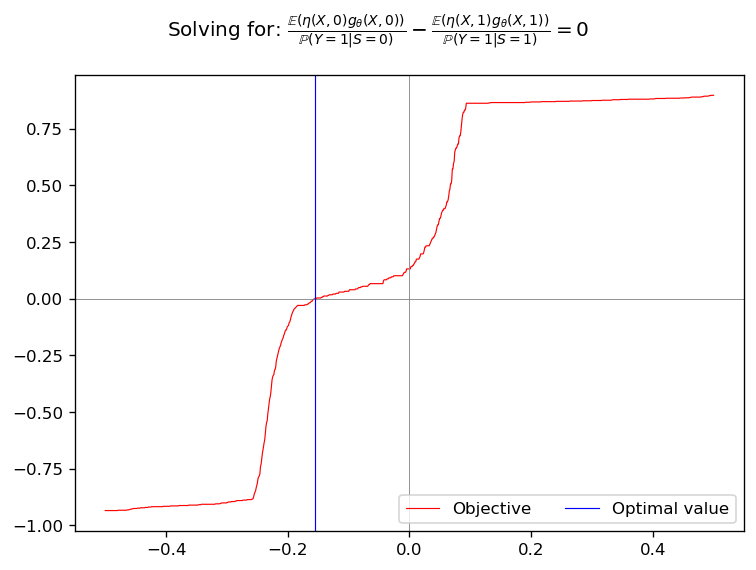

In [21]:
thetas = np.linspace(-.5, .5, 1000)
fig, ax = plt.subplots(dpi=120)
ax.plot(thetas, [objective(t, y_pred, y_prob, St) for t in thetas], color='red', label='Objective', lw=.7)
ax.axvline(0, color='gray', lw=.5)
ax.axhline(0, color='gray', lw=.5)
ax.axvline(theta, color='b', label='Optimal value', lw=.7)
fig.suptitle(r'Solving for: $\frac{\mathbb{E}(\eta(X, 0)g_{\theta}(X, 0))}{\mathbb{P}(Y=1|S=0)} - \frac{\mathbb{E}(\eta(X, 1)g_{\theta}(X, 1))}{\mathbb{P}(Y=1|S=1)} = 0$')
fig.tight_layout()
ax.legend(ncol=2);
fig.savefig('recalibration.png')


In [22]:
f'Proportion of 0\'s in the prediction: {100 * np.sum(1-y_calib) / len(y_calib)} %'

"Proportion of 0's in the prediction: 61.3 %"

In [23]:
print(
    tabulate(
        [['Bayes', bayes_acc, bayes_fairness],
         ['Estimated', estim_acc, pred_fairness],
         ['Calibrated', calib_acc, calib_fairness]], 
        headers=['Accuracy', '(Un)fairness'], tablefmt='grid'
    )
)

+------------+------------+----------------+
|            |   Accuracy |   (Un)fairness |
+============+============+================+
| Bayes      |      0.987 |      0.0578512 |
+------------+------------+----------------+
| Estimated  |      0.975 |      0.206612  |
+------------+------------+----------------+
| Calibrated |      0.984 |      0.0059964 |
+------------+------------+----------------+


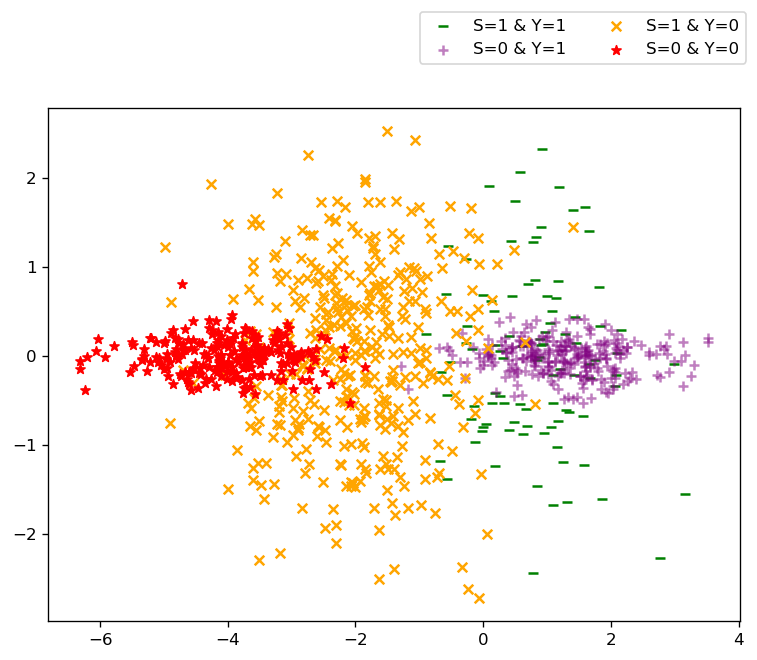

In [24]:
plot(Xt, y_pred, St)